In [73]:
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [74]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    # q_stat(Ljung-Box Q Statistic:LBQ): a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. Instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags, and is therefore a portmanteau test
    # acf(x, nlags=lags) if nlags is None, default:min(10 * np.log10(nobs), nobs - 1)
    # nobs: # of observations
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    # adfuller: Augmented Dickey-Fuller unit root test
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    # moment calculate: 1-mean, 2-var, 3-skew, 4-kurtosis
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    # print(f'Results of moment[1, 2, 3, 4]\n{s}')
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(top=.9)

In [75]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2003', '2023').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100)  # rescale to faciliate optimization
nasdaq_returns.tail()

DATE
2022-12-22   -2.202068
2022-12-23    0.207305
2022-12-28   -1.360873
2022-12-29    2.559660
2022-12-30   -0.110864
Name: NASDAQCOM, dtype: float64

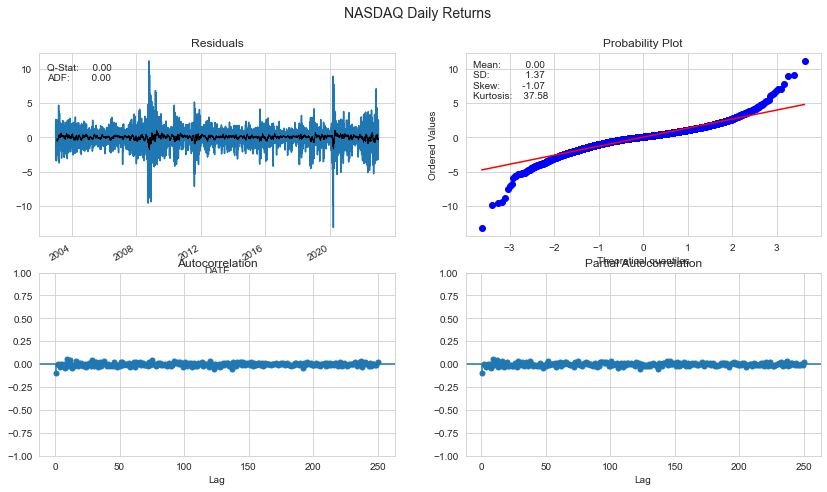

In [76]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

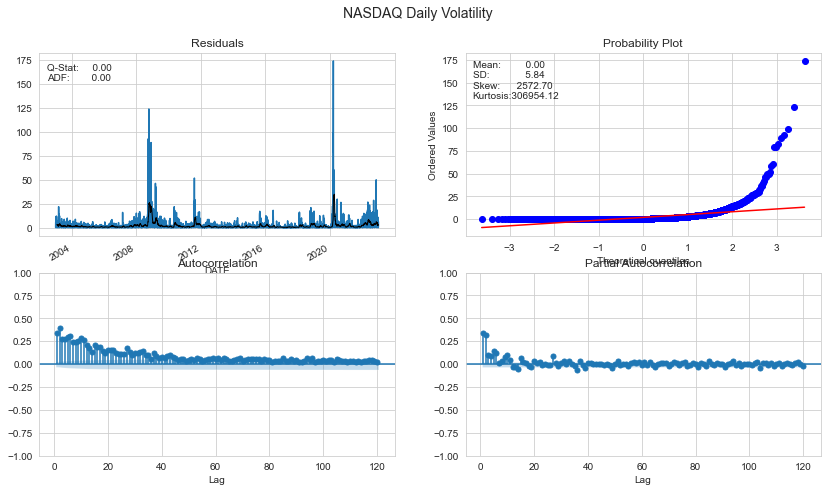

In [77]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

In [78]:
trainsize = 8 * 252  # rolling 8 years btw 2003 & 2023 data for estimation by GARCH MDL
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05), upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
# GARCH MDL estimation to get the linear relationship from the volatility of the past data
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T - 1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t + 1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set - mu) ** 2, var])
            # print(f'{t}th: {result}')
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        # if len(df) != 0:
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


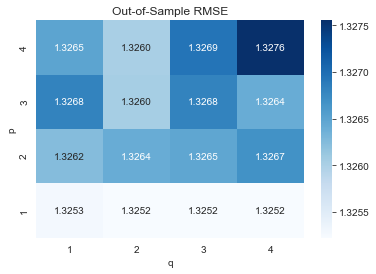

In [82]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

In [83]:
best_p, best_q = 2, 2,
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05), upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: 6851.879913856668
Iteration:     10,   Func. Count:     87,   Neg. LLF: 6848.8057676700055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6848.795921440873
            Iterations: 14
            Function evaluations: 114
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6848.80
Distribution:                  Normal   AIC:                           13709.6
Method:            Maximum Likelihood   BIC:                           13748.5
                                        No. Observations:                 4856
Date:                Thu, Apr 20 2023   Df Residuals:                     4855
Time:        

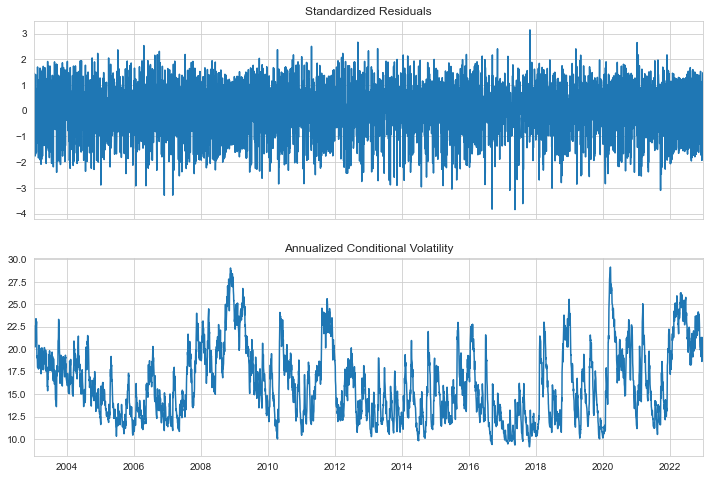

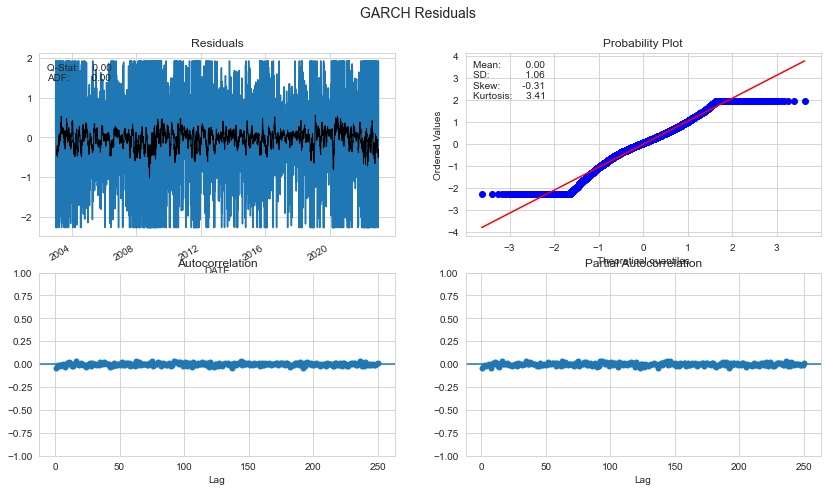

In [84]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
plot_correlogram(best_model.resid.dropna(), lags=250, title='GARCH Residuals')